# Chapter 4 - Alternative Methods, Examples, and Model Checking

In the previous chapters, we have discussed fundamental concepts behind probabilistic programming and probability and introduced several methods of finding the posterior distribution. In this chapter, we are going to introduce several additional methods of finding the posterior, as well as methods for checking the validity of your model.





# Hierarchical models
---

A <a id='hier'>*hierarchical (or multi-level) model*</a> can be used to model <a id='latent'>*latent variables*</a>  (i.e. what you are trying to model through inference, as opposed to observable variables). Examples of latent variables include how healthy or happy an individual is - such variables cannot be observed directly, but can be inferred computationally. While health itself cannot be directly quantified, predictors of health (such as number of doctor's visits per year, days of exercise per week, or servings of vegetables eaten per day) can be quantified.

Hierarchical models are useful for inferring the posterior when one has a more complicated problem. In previous examples, we have assumed that our observations are independent of one another. In this chapter, we will now consider the alternative case where observations are dependent on one another. A hierarchical model can be used to answer the following kinds of questions:

- what grade will a student/all of the students in the class get on a final exam given their grade in the class before the final?
- for a team sport, how does an individual athlete's performance affect the team's overall performance?

A hierarchical model uses inferred dependencies (with a multi-layered, or hierarchical approach) to model the posterior. Recall, we previously mentioned the concept of *hyperparameters*, or the parameters of the prior distribution, which is used when making hierarchical models. The priors of the hyperparameters are called <a id ='hyperprior'>*hyperpriors*</a>.


%% insert generative model diagram 



### Example


Let's try an example. There are many coffee plantations in the state of Hawaiʻi. The [coffee borer beetle](https://en.wikipedia.org/wiki/Coffee_borer_beetle) is a problem for coffee growers worldwide and can cause coffee plants to die. Note that the problem we are going to consider does not represent the true behavior of the coffee borer beetle and is simplified for the purposes of this example.

We want to analyze the infection rate of four Hawaiian islands: Kaua'i, O'ahu, Maui and Hawai'i. Each island has coffee plantations (5 on Kauaʻi, 8 on Oʻahu, 7 on Maui, 10 on Hawaiʻi) and each plantation is divided into sections of the same area (the ratios between the area of the section and the area of entire plantation are given in the problem). Sections are created in order to prevent beetles from spreading over the plantation. This means that if a beetle gets into one section, then all the plants in this section will be affected soon afterwards, but the neighboring sections will not be impacted. Therefore, each section is considered either infected or not infected.

<center><img src = "media/chapter4/coffee.jpg" width = "450"></center>


To analyze the infection rate, we randomly choose plantations on each island and sample $50$ sections from each plantation. We also have the ratio of the section area to the plantation area for each of the chosen plantations, because it might be used in the generative model.

We are given the following data:


*   `observed_data` = an array of integers between $0$ and $50$ that represent the number of infected areas for each of the chosen plantations

*   `ratio` = an array of numbers between $0$ and $1$ that represent the ratio of area of the section to the area of plantation

* `islands` = an array of characters ('H', 'M' , 'O', 'K'), representing the island where the chosen plantation is located, i.e. Hawai'i, Maui, O'ahu, and Kaua'i, .

The first step in solving the problem, as usual, is to create a generative model. Since the generative model in this problem has several layers, we are going start from a simple case and add the layers gradually.

To start, let's consider just one plantation. We need to sample $50$ sections from the plantation and determine how many of them are infected. What distribution can we use to generate the number of infected sections? We can use the binomial distribution with a parameter $n=50$ and some parameter $p$. The following code generates this smaller model in PyMC3:


```
with pm.Model() as model:
    infected = pm.Binomial("infected", n=50, p=p, observed = observed_data)
```
In the context of the smaller problem, $p$ is our prior, which can be generated using the continuous uniform distribution with parameters $a=0$ and $b=1$ if we don't have any additional information about the plantation. But there is more information about $p$ from our initial problem. Recall that we are also given the `ratio`, which is useful because we are currently only considering one plantation. How can different ratios change the rate of infection?  If just one beetle arrives in the section of plantation with a ratio of $1/100$, then it almost immediately will infect $1/100$ of plantation. If, instead, the ratio of the same plantation is $1/4$, then one beetle would quickly infect quarter of the plants. So, we need to take into account the fact that the smaller the ratio is, the less damage beetle will cause to the plantation. We also are going to assume that although the sections help from spreading the beetle over the whole plantation, it is likely that the beetle won't be alone, and others might affect other sections. So $p$ will more likely be something close to $0$ or $1$ rather then $0.5$. The last thing we are going to assume, is that plantation can be in a good shape or in a bad shape. That means that if it's in a good shape, then it has more chances of not getting completely infected by the beetles than of getting infected and vice versa.

Recall, that the distribution that is used to parameterize for the Binomial is the Beta distribution with parameters $a$ and $b$. Also recall that if $a<1$ and $b<1$, then the outcome is more likely to be close to $0$ or $1$, respectively, that is exactly what we are looking for. We also know that $a>b$ gives higher probability of getting value close to $1$, and $a<b$ gives higher probability of getting outcome close to $0$. 

<center><img src = "media/chapter4/betadist.jpg" width = "450"></center>

Considering the plantation's ratio, we can choose parameters for the beta distribution the following way:


*   if a plantation is in a good shape: $a=1/4 -$`ratio`, $b=3/4+$`ratio` ;
*   if a plantation is in a bad shape: $a=3/4+$`ratio` , $b=1/4-$`ratio`;

This is not the only choice of $a$ and $b$ that would work, but it satisfies all the conditions mentioned above, therefore, it is a good choice for us.

The choice of good/bad shape can be generated using the Bernoulli distribution with some parameter $I$.

With the above adjustments, the generative model can be implemented the following way:


```
with pm.Model() as model:
    shape = pm.Bernoulli("pl", p = I)
    a = pm.math.switch(shape < 1/2, 1/4 - ratio, 3/4 + ratio)
    b = pm.math.switch(shape < 1/2, 3/4 + ratio, 1/4 - ratio)
    p = Beta("p", alpha = a, beta = b)
    infected = pm.Binomial("infected", n=50, p=p, observed = observed_data)
```

Suppose we also want to take into account the island the considered plantation is from. We know from the original problem that each island has some infection rate. We can say that this rate affects whether the plantation is in a good or bad shape. Therefore, the parameter $I$ is exactly what we want to infer. Since we don't know anything about it, we can make it an uninformative prior, that is to generate it using the uniform continuous distribution with parameters $a=0$ and $b=1$. So, the finished model for one plantation will be the following:

```
with pm.Model() as model:
    I = pm.Uniform("I", a = 0, b = 1)
    shape = pm.Bernoulli("pl", p = I)
    a = pm.math.switch(shape < 1/2, 1/4 - ratio, 3/4 + ratio)
    b = pm.math.switch(shape < 1/2, 3/4 + ratio, 1/4 - ratio)
    p = Beta("p", alpha = a, beta = b)
    infected = pm.Binomial("infected", n=50, p=p, observed = observed_data)
```

The last step is to transform the above model into a model that has data about more than one plantation.  The following image summarizes the generative model for the problem for four islands and more than one plantation per island as described above.


<center><img src = "media/chapter4/coffee_model.jpg" width = "650"></center>


This can be modelled in PyMC3 in the following way:



In [0]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(435)
#data for hierarchical
H = 10
M = 7
O = 8
K = 5
sample_size = 50
H_ = 0.56
M_ = 0.32
O_ = 0.78
K_ = 0.11
islands = np.array(["H"]*H+["M"]*M+["O"]*O+["K"]*K)
rates = np.array([H_]*H+[M_]*M+[O_]*O+[K_]*K)
ratio = 1/np.random.randint(10,100,len(islands))
binom = np.array([np.random.binomial(n=1,p=p_rat,size=1)[0] for p_rat in rates])
opt1=3/4+ratio
opt2 =1/4-ratio
a = binom*(opt1)+(1-binom)*opt2
b = binom*opt2+(1-binom)*(opt1)
beta = np.array([np.random.beta(a[i],b[i],size=1)[0] for i in range(len(a))])
observed_data = np.array([np.random.binomial(p = beta_, n = sample_size, size=1)[0]for beta_ in beta])
#grid
#plt.plot(np.arange(0,30),grid)

In [0]:
# Hierarchical model

import pymc3 as pm
import numpy as np

#islands= np.array(['H', 'H','H','M','O','M','O','K','O','K','K','M','M'])
#ratio = np.array([1, 1,1,2,3,2,3,4,3,4,4,2,2])*1/100
#observed_data = np.array([0, 0,1,5,6,4,9,4,3,4,4,2,2])
sample_size = 50

N = len(observed_data)

with pm.Model() as model:
  H = pm.Uniform("H", 0, 1)
  M = pm.Uniform("M", 0, 1)
  O = pm.Uniform("O", 0, 1)
  K = pm.Uniform("K", 0, 1)
  
  I = pm.math.switch(islands == 'H', H,
                     pm.math.switch(islands == 'M', M,
                                    pm.math.switch(islands == 'O', O, K)))
  shape = pm.Bernoulli("shape", I, shape = N)
  a = pm.math.switch(pm.math.lt(shape, 1/2), 1/4 - ratio, 3/4 + ratio)
  b = pm.math.switch(pm.math.lt(shape, 1/2), 3/4 + ratio, 1/4 - ratio)
  #pm.math.eq(shape, 0)
  p = pm.Beta("p", a, b, shape = len(islands))
  Grid = pm.Binomial("grid", p = p, n = sample_size, 
                     shape = N, observed = observed_data)
  trace = pm.sample(20000)
  burned_trace = trace[1000:]
  
  

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [p, K, O, M, H]
>BinaryGibbsMetropolis: [shape]
100%|██████████| 20500/20500 [02:15<00:00, 150.97it/s]
There were 5378 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11049 divergences after tuning. Increase `target_accept` or reparameterize.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8dfa165710>,
      dtype=object)

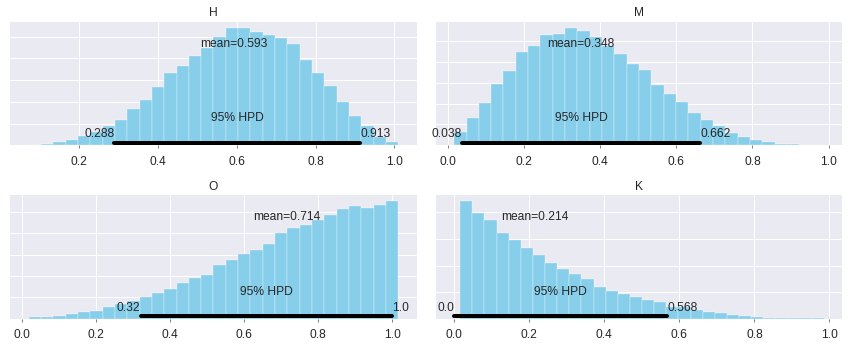

In [0]:
pm.plot_posterior(burned_trace, varnames=['H', 'M', 'O', 'K'])

Our hierarchical model shows that on average, 59.3%, 34.8%, 71.4%, and 21.4% of plantations are potentially infected for the islands of Hawai'i, Maui, O'ahu, and Kaua'i, respectively. 

The <a id='hpd'>*95% Highest Posterior Density (HPD)*</a>  represents the likely range of values within a 95% confidence interval for the posterior distribution (its range is indicated by the black bar in the figure above). In other words, the HPD can be thought of the range of values for the posterior of a modelled parameter with a p = 0.95. 

The HPD for our hierarchical model ranges from 0% plantation infection rate (on all islands) to 100% on O'ahu, given our model inputs. 

In summary:

<table>
  <tr>
    <td><b><center>Island</center></b></td>
    <td><center>Hawai'i</center></td>
    <td><center>Maui</center></td>
    <td><center>O'ahu</center></td>
    <td><center>Kaua'i</center></td>
  </tr>
  <tr>    
    <td><b><center>Average % Infected</center></b></td>
    <td><center>59.3%</center></td>
    <td><center>34.8%</center></td>
    <td><center>71.4%</center></td>
    <td><center>21.4%</center></td>
  </tr>
   <tr>    
    <td><b><center>95% HPD</center></b></td>
    <td><center>28.8 - 91.3%</center></td>
    <td><center>3.8 - 66.2%</center></td>
    <td><center>32 - 100%</center></td>
    <td><center>0 - 56.8%</center></td>
  </tr>
  </table>
    

The hierarchical approach allowed us to look at each island separately, as well as look at the effects at the plantation and island scale. As you can see from the 95% HPD, the model results in significant overlap in infection rates between all islands.

Hierarchical models are generally considered more robust than non-hierarchical approaches because of the linkage between the model components through the hyperpriors. This linkage (sometimes referred to as *shrinkage*) means the model and resulting posteriors are less likely to be skewed by outliers and thus is an improvement creating multiple, separate models to answer the same questions the hierarchical model can answer.


# Method Criticism


---


Once you have a working model that you pretty confident in, it is time to criticize it (i.e. make sure the modelled values are valid). There are several ways to do this, including:

* posterior predictive checks
* mock-up data analysis

Model comparison or criticism is important because a model is just an inference; the techniques that are subsequently discussed may be used to evaluate the model or to determine the best model (in the case where several different models have been constructed to answer the same problem)

Two important concepts in statistics are *overfitting* and *underfitting*, both which result from using too many or too few parameters in the model. <a id='over'>*Overfitting*</a> can occur when there are too many parameters to model the problem, and the model is just learning to fit the exact data it is given. <a id='under'>*Underfitting*</a> represents the opposite case, where too few parameters are used and the model is just too simplistic to accurately model the problem. You can read more about overfitting and underfitting [here](https://en.wikipedia.org/wiki/Overfitting).

Overfitting and underfitting are just two of the potential problems that can occur when building a model - which is why it is important to check the model's validity.

### Posterior predictive checks
A <a id='ppc'>*posterior predictive check*</a> checks the validity of your model by using the posterior generated from the model to predict future data and then checking how well the newly generated data matches the observed data. This concept is easily demonstrated with an example.

Let's try a problem using the daily average temperatures in Honolulu, with a mean of 85 degrees and a standard deviation of 5 degrees.

First, let's generate the data and plot it.

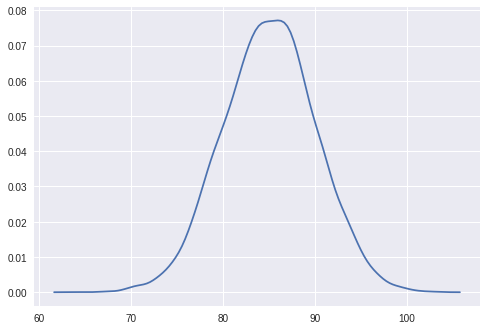

In [0]:
# posterior predictive check
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt

# temperature data, make fake dataset with mean = 85 degrees, sd = 5 degrees
mean = 85
sd = 5
time = 365 * 30

# generate temperature data
data = np.random.normal(mean,sd,time)
#random.seed()

# plot of initial data
sns.kdeplot(data)


We now have our observed data, let's proceed with constructing and running a model as follows:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [s, mu]
100%|██████████| 1600/1600 [00:06<00:00, 253.43it/s]
The acceptance probability does not match the target. It is 0.8996544696004435, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9451785490737427, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa3cff544e0>,
      dtype=object)

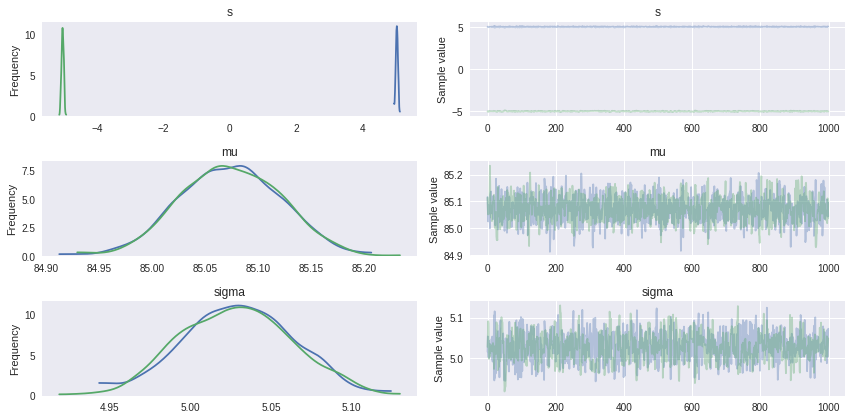

In [0]:
# model

with pm.Model() as temp:
  mu = pm.Uniform('mu', 60, 110)
  s = pm.Normal('s', mu = 0, sd = 5)
  sigma = pm.Deterministic('sigma', pm.math.abs_(s))
  y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
  temp_norm = pm.sample(1100)
  
chain_norm = temp_norm[100:]
pm.traceplot(chain_norm)

We can also print out a summary of the model results using the summary function in PyMC3:


In [0]:
# summary of model results

pm.summary(chain_norm)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
s,0.000848,5.029000,0.502889,-5.088446,5.082836,1.000525,207.638671
mu,85.072618,0.047362,0.001086,84.988153,85.169460,1633.312571,0.999630
sigma,5.028884,0.034245,0.001041,4.965213,5.095583,953.010782,1.000112


Now that we have our modelled results, we can perform a posterior predictive check using the `sample_ppc `
function which is included in the PyMC3 package. After the posterior predictive check is performed, we can plot our data with our modelled predictions to compare results and see if the model we created is a good fit.

100%|██████████| 100/100 [00:01<00:00,  2.24it/s]
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


Text(0.5,0,'Temperature (degrees F)')

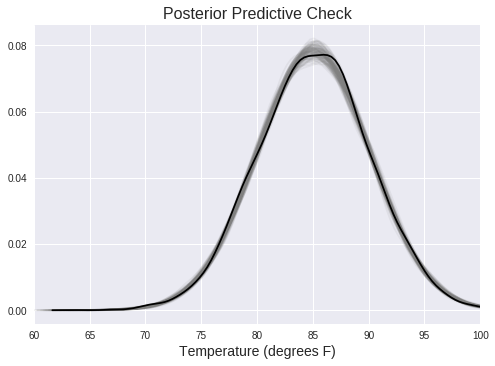

In [0]:
# perform posterior predictive check and plot comparison on results

# generate a posterior predictive check by drawing 100 generated data sets 
# from modelled results using the sample_ppc function

ppc = pm.sample_ppc(chain_norm, samples=100, model=temp)

# plot ppc samples (grey) with observed data (black) to compare
for i in ppc['y']:
  sns.kdeplot(i, c='grey', alpha = 0.1)

sns.kdeplot(data, c='k')
plt.xlim(60, 100)
plt.title('Posterior Predictive Check', fontsize=16)
plt.xlabel('Temperature (degrees F)', fontsize=14)


For this example, the posterior predictive check matches the observed data well, so we can be confident in our model. Of course, in this example we generated fake data from a normal distribution, so our model results match our observed data extremely well. For a real dataset with outliers, the match between the observed data and the modelled data will likely not be so similar.

### Mock-up Data Analysis

Another way to test our model is to perform a mock-up data analysis. In this case we don't even need the observed data, we are going to construct it ourselves. 

We need to choose the pre-set parameter and generate the data with this parameter using a generative model. After that we use the model one more time to infer back the parameter. If the model fails the task, then there is a chance that it is not right for the problem.

We are going to use the example introduced above to perform the mock-up data analysis. The model we were using is the following:

```
with pm.Model() as temp:
  mu = pm.Uniform('mu', 60, 110)
  s = pm.Normal('s', mu = 0, sd = 5)
  sigma = pm.Deterministic('sigma', pm.math.abs_(s))
  y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
```
There are two parameters: mu and sigma. Let's assign some values to them, suppose $mu=70$ and $sigma=5$. Then we can generate mock-up data the following way:


In [0]:
import pymc3 as pm

mu = 70
sigma = 5

y_ = pm.Normal.dist(mu,sigma,shape = 1000)
data = y_.random()

Next step is to use the model to infer the parameters.

In [0]:
with pm.Model() as temp:
  mu = pm.Uniform('mu', 60, 110)
  s = pm.Normal('s', mu = 0, sd = 5)
  sigma = pm.Deterministic('sigma', pm.math.abs_(s))
  y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
  temp_norm = pm.sample(1100)
  
chain_norm = temp_norm[100:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [s, mu]
100%|██████████| 1600/1600 [00:01<00:00, 835.66it/s]
The acceptance probability does not match the target. It is 0.8844852036330192, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9234885562034889, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa3d4db6198>,
      dtype=object)

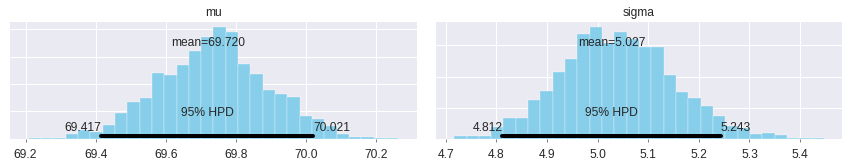

In [0]:
pm.plot_posterior(chain_norm, varnames=['mu','sigma'])

As we can see, the results match chosen parameters well. Therefore, there is a good chance the model will succeed with real data.

These are just two ways of checking a model's validity, but there are many more. If you are interested in reading more, some good resources can be found [here](https://am207.github.io/2018spring/wiki/bioassay_pymc3.html#model-checking) and [here](https://docs.pymc.io/api/diagnostics.html).

# Mixture models


---



A <a id='mm'>*mixture model*</a> is useful when the problem you are trying to solve is comprised of several distributions (i.e. a mixture of distributions). For instance, let's say you are purchasing produce at the grocery store and want to compare the price of a banana picked up at random. The grocery store has two types of bananas for sale - organic (typically more expensive) and non-organic (typically cheaper) and can be modelled with a Gaussian distribution. When a mixture model uses a Gaussian distribution, it is called a <a id='gmm'>*Gaussian Mixture Model*</a> (abbreviated GMM). In this case, the data will show several distributions, as shown below in the figure:

%%insert graphic like this, with grocery store example (i.e. replace 'waiting' with price per banana, and the probabilities to match below) below illustrated: 

![alt text](media/chapter4/mixture.png)

In the above figure, the red and blue distributions represent different <a id='mc'>*mixture components*</a>, or distributions with different parameters (such as the mean and variance for a Gaussian distribution). For the bananas, the two mixture components would be non-organic (in red on the plot, where mean = $80$ cents per banana and standard deviation = $8$ cents) and organic (in blue on the plot, where mean = $95$ cents per banana and standard deviation = $12$ cents). A <a id='mp'>*mixture proportion*</a> describes the probability of choosing a non-organic or organic banana at random. In this case, grocery store stocks $65%$ non-organic bananas and $35%$ organic bananas.


**To recap, our mixture components (the number of mixture components is written as $k$) are** (where subscript $n$ refers to not organic and $o$ refers to organic):

* non-organic ($\mu_n$ = $80$ cents, $\sigma^2_n$ = $8$ cents)
* organic ($\mu_o$ = $95$ cents, $\sigma^2_o$ = $12$ cents)

**Our mixture proportions (written as $\pi_k$) are:**
* non-organic ($\pi_n$ = 0.65)
* organic ($\pi_o$ = 0.35)

A *mixture model*, in other words, describes data which originate from one of $k$ mixture components.

Let's try an example.

### Example 1. 
Suppose we go to different stores in Honolulu and buy 100 bananas. Some of them are organic and some of them are not. We only keep track of the price of each banana. What is a probability that a random banana out of this 100 will be organic?

Using the mixture components above, we want to create a generative model that would describe this problem. Let $p$ be the mixture proportion of organic bananas ($\pi_o=p$). Then mixture proportion of non-organic bananas is $\pi_n=1-p$. Since we don't know anything about the proportions, we can assume $p$ is chosen uniformly between $0$ and $1$.The price of each banana can be determined by using Gaussian distributions with parameters specified above (i.e., $\mu_n=.80, \sigma_n^2=0.08, \mu_o=0.95,\sigma_o^2=0.12$). The last step is to "mix" all of the above information into one model. This can be done using the pm.NormalMixture function.

The model can be implemented in PyMC3 the following way.

[1.11946889 1.23052365 1.14342984 1.14796919 1.04578976 0.94539969
 0.89996968 1.01886653 0.99551995 0.99750327 0.87322432 0.87535821
 0.8183297  0.94508055 0.99877797 1.17206196 0.99453939 0.94708979
 1.05582192 1.15212632 0.7964329  0.72225465 0.74559812 0.70326838
 0.85560351 0.85534109 0.81629381 0.75423151 0.84970896 0.73311464
 0.77905686 0.81932031 0.7877099  0.72415399 0.81597298 0.75513312
 0.57571913 0.87146405 0.83391698 0.85069176 0.80156589 0.88739723
 0.85023654 0.83066583 0.91055427 0.81421495 0.70529833 0.8126596
 0.80211278 0.84803348 0.89864616 0.86722379 0.78014934 0.68597636
 0.93564059 0.80590237 0.77297886 0.76011001 0.93047804 0.69047665
 0.80736132 0.68837212 0.78109358 0.7379102  0.82910752 1.04042117
 0.76964514 0.6661856  0.83952907 0.74602366 0.83671638 0.86522255
 0.72327574 0.74938734 0.78292846 0.69500564 0.80047435 0.88766048
 0.92080974 0.87462347 0.68804223 0.71769912 0.81413671 0.92942759
 0.9047748  0.69417712 0.83345588 0.70591998 0.73648578 0.68066

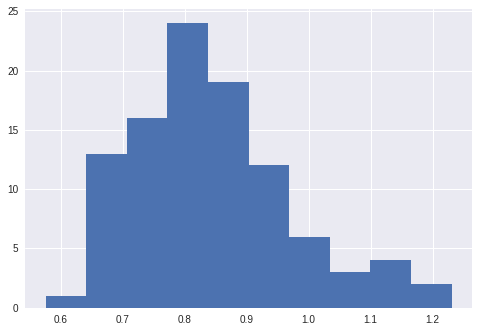

In [0]:
#@title
# generating the data used for the model
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
np.random.seed(4500)
# define the standard deviation (sigma) and mean
mu_n = 0.80
mu_o = 0.95
sd_n = 0.08
sd_o = 0.12

N_o = 20
N_n = 80

x_1 = np.random.normal(mu_o, sd_o, N_o)
x_2 = np.random.normal(mu_n, sd_n, N_n)

x = np.append(x_1, x_2)
plt.hist(x,10)
print(x)

In [0]:
import pymc3 as pm
import numpy as np

data = x

mu_n = 0.80
mu_o = 0.95
sd_n = 0.08
sd_o = 0.12

with pm.Model() as model:
    p = pm.Uniform('p', 0, 1)
    mixture = pm.NormalMixture('mix', w=[p, 1 - p], mu=[mu_o, mu_n], 
                               sd=np.array([sd_o,sd_n]), observed = data)
    trace = pm.sample(20000)
    burned_trace = trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]
100%|██████████| 20500/20500 [00:11<00:00, 1792.09it/s]


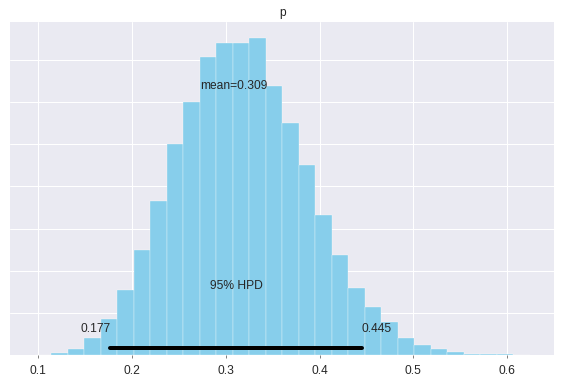

In [0]:
pm.plot_posterior(burned_trace)

This simple mixture model resulted in about a 30% mean probability (with a 95% HPD from about 18 to 45%) of randomly picking an organic banana out of the 100 we purchased. This makes sense because you are less likely to pick up an organic banana compared to a non-organic banana.

Let's try a mixture model that's a little more complicated now.

### Example 2.

There are three types of fish living in a pond. [Researchers](https://www.researchgate.net/lab/Yoshizawa-Lab-Masato-Yoshizawa) have determined that the only distinguishing features between them are their light preferences:


1.   Fish that likes to be in the light. Usually spends around $0.87$ of the time in the light.
2.   Fish that likes to be in the dark. It spends around $0.18$ of the time in the light.
3.   Fish that likes to be in between light and dark. It spends around $0.51$ of the time in the light.

It was also determined that standard deviation is the same for all three types of fish and is $0.11$.** Therefore, our mixture components ($k$) are:**

* Type 1 Fish - preference for light ($\mu$  =  0.87, $\sigma^2$  =  0.11)
* Type 2 Fish - preference for dark ($\mu$  =  0.18,  $\sigma^2$  =  0.11)
* Type 3 Fish - preference for both light and dark ($\mu$  =  0.51,  $\sigma^2$ =  0.11)


We observe the pond for one hour and record how much time each fish stays in the light. We want to determine how many fish of each type are in the pond.

---
This problem can be solved using a mixture model.

The first step, as usual, is to create a generative model that describes the problem. 
The observed data is a vector where i-th element is a value between $0$ and $1$ that corresponds to the time i-th fish spent in the light. So, we are given the number of fish in the pond, $N$, that is the length of the vector.

The model consists of two important parts: the proportions of different types in a pond (weights) and the distributions that are used to determine the time spent in the light for each type of fish.

The distribution that we are going to use to generate weights is called the <a id='dirichlet'>*Dirichlet distribution*</a> with parameters $a = (a_1,a_2,...,a_N)$. This distribution divides the interval $(0,1)$ into $N$ pieces of lengths $w_1,w_2,...,w_N$; all that will add up to one. That is exactly what we need for determining our weights (or mixture proportions, $\pi$). We also will choose an uninformative prior $a=(1,1,...,1)$

Sidenote: The Dirichlet distribution with $N=2$ is a Beta distribution.

Because we know the mean and standard deviation for each type of fish, we are going to use the Gaussian distribution to determine how much time fish spends in the light:

1.   Gaussian(0.87, 0.11)
2.   Gaussian(0.18, 0.11)
3.   Gaussian(0.51, 0.11)

Now, the last step of the generative model is to "mix" all of the above information into one model. This can be done in PyMC3 using the `pm.Mixture` or `pm.NormalMixture` function. Since our distributions are Gaussian (normal), we are going to use the latter one.

This model can be implemented in PyMC3 the following way:



In [0]:
#@title
# generating the data used for the model
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
np.random.seed(4500)
# define the standard deviation (sigma) and mean
sigma = 0.11
mean_1 = 0.87
mean_2 = 0.18
mean_3 = 0.51
N1 = 500
N2 = 700
N3 = 800

x_1 = np.random.normal(mean_1, sigma, N1)
x_2 = np.random.normal(mean_2, sigma, N2)
x_3 = np.random.normal(mean_3, sigma, N3)

x_1 = (x_1 > 1) * np.random.uniform(mean_1, 1, N1) + (x_1 <= 1) * x_1
x_2 = (x_2 < 0) * np.random.uniform(0, mean_2 + 0.05, N2) + (x_2 >= 0) * x_2

x = np.append(x_1, x_2)
x = np.append(x, x_3)

#nbins = 30

#plt.hist(x,nbins)
#print(x)

In [0]:
import pymc3 as pm
import numpy as np

data = x
N = len(data)

mu_1 = 0.87
mu_2 = 0.18
mu_3 = 0.51
sd = 0.11

with pm.Model() as model:
    weights = pm.Dirichlet('weights', a=np.array([1.0, 1.0, 1.0]))
    mixture = pm.NormalMixture('mix', w=weights, mu=[mu_1,mu_2,mu_3], 
                               sd=sd, observed=data)
    #step = pm.Metropolis()
    trace = pm.sample(20000)
    burned_trace = trace[1000:]
  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [weights, mu_3, mu_2, mu_1]
100%|██████████| 20500/20500 [01:44<00:00, 197.07it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f57d54ddc50>,
      dtype=object)

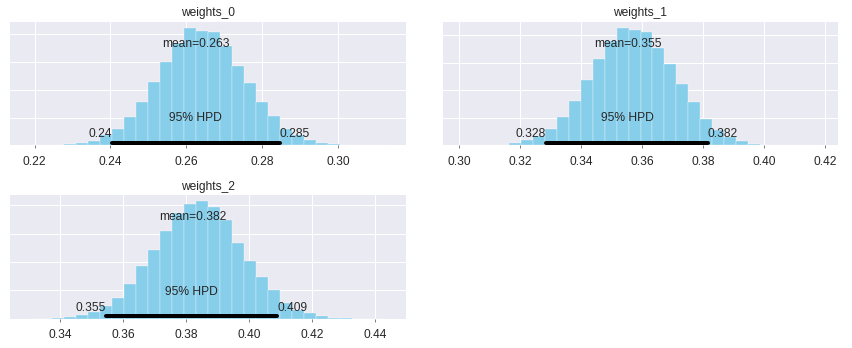

In [0]:
pm.plot_posterior(burned_trace, varnames=['weights'])

Note that it is not necessary for us to know the means for the Gaussian distributions we used above. The model can find the means that fit the observed data. So, let's try to set $\mu_1, \mu_2, \mu_3$ as priors drawn from Uniform distributions. We can choose these priors to be informative based on the light preferences of each group of fish. So, let mu_1~Uniform(0.75,1), mu_2~Uniform(0,0.25), mu_3~Uniform(0.4,0.6). The implemented model looks the following way.

In [0]:
import pymc3 as pm
import numpy as np

data = x
N = len(data)

sd = 0.11

with pm.Model() as model:
    mu_1 = pm.Uniform('mu_1', 0.75, 1)
    mu_2 = pm.Uniform('mu_2', 0, 0.25)
    mu_3 = pm.Uniform('mu_3', 0.4, 0.6)
    weights = pm.Dirichlet('weights', a=np.array([1.0, 1.0, 1.0]))
    mixture = pm.NormalMixture('mix', w=weights, mu=[mu_1,mu_2,mu_3], 
                               sd=sd, observed=data)
    #step = pm.Metropolis()
    trace = pm.sample(20000)
    burned_trace = trace[1000:]

In [0]:
pm.plot_posterior(burned_trace, varnames=['weights'])

In [0]:
pm.plot_posterior(burned_trace, varnames=['mu_1','mu_2','mu_3'])

As you can see, the posterior distributions of weights are about the same as in the model with fixed means in Gaussian distributions. Moreover, posterior distributions of means are also acuurate.

The mixture model allowed us to partition the proportion of each type of fish. In this mixture model, we did not apply our assumptions about the means beforehand in the model, instead we used an uniformative prior. The results of the mixture model show that fish type 1 (the one that likes light) makes up about 26% (with a 95% HPD of about 24 to 28%) of the fish in the pond, fish type 2 (the one that likes the dark) makes up about 36% (with a 95% HPD of about 33 to 38%) of the fish in the pond, and fish type 3 (the one that likes both light and dark) is makes up about 38% (with a 95% HPD of about 36 to 41%) in the pond.

Go ahead and try to do the same problem, this time using an informative prior (i.e. using the means for each type of fish in the model instead of the uniformative prior). The resulting posterior distributions should be very similar.

In this chapter we discussed two different Gaussian mixture models, however other distributions can also be used (for instance, the Poisson distribution is commonly used for mixture models dealing with count data). Mixture models are useful for clustering multiple distributions within a population, such as the probability of picking an organic banana at random or partitioning the proportion of types of fish in a pond.

---

This chapter concludes the Introduction to Probabilistic Programming module. In this module, we learned the how to construct a generative model, basics of probabilistic programming with the PyMC3 package in Python, several common probability distributions and their applications, Bayesian statistics, ways to model a problem, and how to check a model. With this introductory course, you should be able to construct simple models and have the framework to approach more complicated ones.

### <u>Definitions</u>

%% these will be hyperlinked within the chapter

<a href='#mm'>**mixture model**</a>: a type of model that is used to differentiate groups within a population by parsing different distributions.

<a href='#gmm'>**Gaussian mixture model (GMM)**</a>: a mixture model that uses the Gaussian distribution.

<a href='#mc'>**mixture component ($k$)**</a>: part of a mixture model, refers to distributions with different parameters.

<a href='#mp'>**mixture proportion ($\pi$)**</a>: part of a mixture model, refers to the proportion or weights of each group.

<a href='#dirichlet'>**Dirichlet distribution**</a>: a probability distribution where each number in the set must add up to 1, commonly used when working with categorical distributions.

<a href='#hier'>**hierarchical (multi-level) model**</a>: a type of probabilistic model that has layered dependencies.

<a href='#latent'>**latent variables**</a>: variables that can be inferred, but not directly observed.

<a href='#hyperprior'>**hyperprior**</a>: prior of a hyperparameter

<a href='#ppc'>**posterior predictive check**</a>: a way to check model validity using the posterior to predict future data.

<a href='#hpd'>**Highest Posterior Density (HPD)**</a>: the range of values for which the posterior distribution are most likely to occur. This is often given at the 95% confidence interval.

<a href='#over'>**overfitting**</a>: when too many parameters are used in a model given the data provided, resulting in a model that is too complex and not an accurate representation of the problem.

<a href='#under'>**underfitting**</a>: when too few parameters are used in a model given the data provided, resulting in a model that is too simple and not an accurate representation of the problem.